In [1]:
import numpy as np
import cv2
import colour
from PIL import Image
import matplotlib.pyplot as plt

# Load image in RGB colour space and range [0, 1]

In [2]:
image_path = 'Lena.png'
image = colour.cctf_decoding(colour.io.read_image(image_path, method='Imageio'))

print('first pixel:', image[0,0])
print('image shape:', image.shape)

first pixel: [ 0.76052452  0.25015831  0.20507874]
image shape: (512, 512, 3)


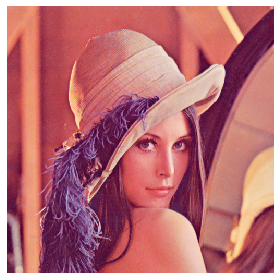

In [3]:
def plot_image(image):
    colour.plotting.plot_image(colour.cctf_encoding(np.clip(image, 0, 1)))

plot_image(image)

# Convert and encode given linear float RGB image to 8-bit RGB

In [4]:
image_8_bit = colour.io.convert_bit_depth(colour.cctf_encoding(image), bit_depth='uint8')

print('first pixel:', image_8_bit[0,0])
print('image shape:', image_8_bit.shape)

first pixel: [226 137 125]
image shape: (512, 512, 3)


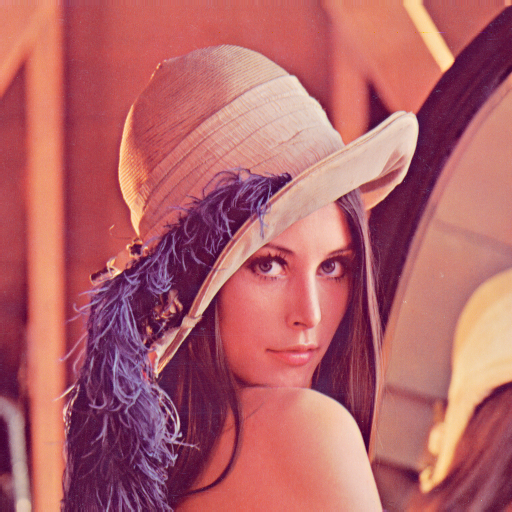

In [5]:
# PIL image
Image.fromarray(image_8_bit)

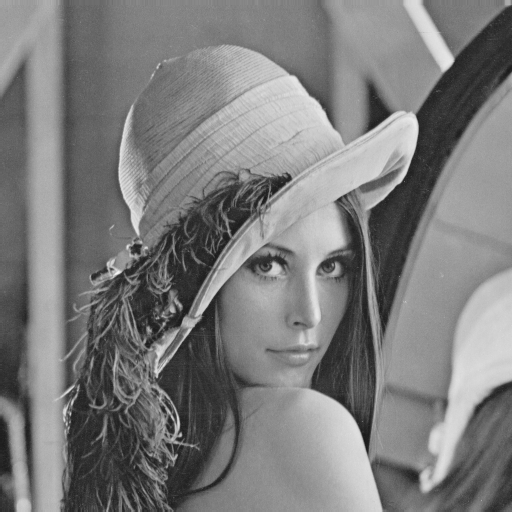

In [6]:
image_8_bit_gray = cv2.cvtColor(image_8_bit, cv2.COLOR_RGB2GRAY)

Image.fromarray(image_8_bit_gray)

# Convert between color spaces

## Convert image from RGB to CIE XYZ and CIE Lab color spaces

In [7]:
D65 = colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65']
D50 = colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D50']

illuminant_RGB = D65
illuminant_XYZ = D50
image_xyz = colour.RGB_to_XYZ(image, illuminant_RGB, illuminant_XYZ,
                                  colour.RGB_COLOURSPACES['sRGB'].matrix_RGB_to_XYZ,
                                  chromatic_adaptation_transform='Bradford')
image_lab = colour.XYZ_to_Lab(image_xyz, illuminant_XYZ)

print('first xyz pixel:', image_xyz[0,0])
print('first lab pixel:', image_lab[0,0])
print('image shape:', image_lab.shape)

first xyz pixel: [ 0.45734643  0.36095947  0.18129974]
first lab pixel: [ 66.59316991  33.92050905  21.71532494]
image shape: (512, 512, 3)


## Convert image from CIE Lab to RGB color space

In [8]:
image_xyz = colour.Lab_to_XYZ(image_lab, illuminant=illuminant_XYZ)
image_rgb = colour.XYZ_to_RGB(image_xyz, illuminant_XYZ, illuminant_RGB,
                  colour.RGB_COLOURSPACES['sRGB'].matrix_XYZ_to_RGB,
                  chromatic_adaptation_transform = 'Bradford')

print('first rgb pixel:', image_rgb[0,0])
print('image shape:', image_rgb.shape)

first rgb pixel: [ 0.76052299  0.25018325  0.20508274]
image shape: (512, 512, 3)


## Convert from sRGB to CMYK color space

In [9]:
rgb = image_8_bit[0,0]
rgbdash = np.array(rgb).astype(np.float) / 255.
if rgbdash.ndim == 1:
    rgbdash = np.expand_dims(rgbdash, axis=0)

# Calculate K as (1 - whatever is biggest out of Rdash, Gdash, Bdash)
K = 1 - np.max(rgbdash, axis=1)

C = (1 - rgbdash[..., 0] - K) / (1 - K)
M = (1 - rgbdash[..., 1] - K) / (1 - K)
Y = (1 - rgbdash[..., 2] - K) / (1 - K)

# Combine 4 channels into single image and re-scale back up to uint8
image_CMYK = np.dstack((C, M, Y, K))
image_CMYK

array([[[ 0.        ,  0.39380531,  0.44690265,  0.11372549]]])

# Square detection

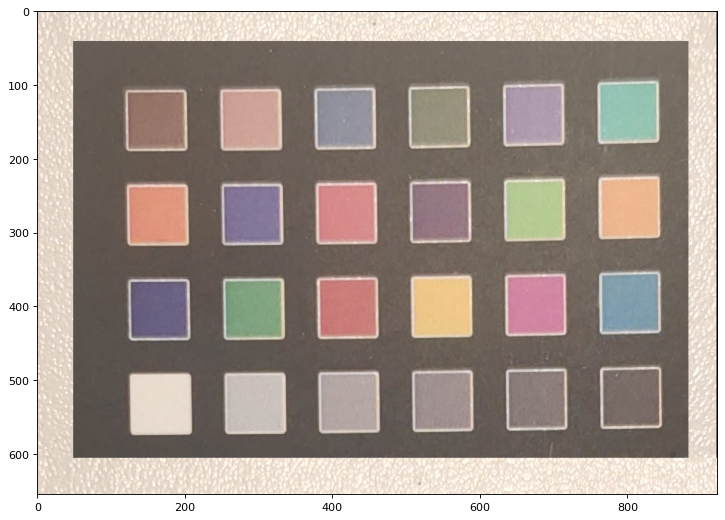

In [10]:
image_bgr = cv2.imread('colour_checker.png')
image_8_bit = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8), dpi=80)
plt.imshow(image_8_bit)
plt.show()

In [11]:
WORKING_WIDTH = 1440
SQUARE_COUNT = 24
RECT_RATIO = 0.75
FIXED_SQUARE_SIZE = (32, 32)

resize_ratio = WORKING_WIDTH / image_8_bit.shape[1]
image = cv2.resize(image_8_bit, None, fx=resize_ratio, fy=resize_ratio)

image_width, image_height = image.shape[1], image.shape[0]
max_area = image_width * image_height / SQUARE_COUNT
min_area = image_width * image_height / SQUARE_COUNT / 5

block_size = int(WORKING_WIDTH * 0.1)
block_size = block_size - block_size % 2 + 1

# Thresholding/Segmentation
image_g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image_g = cv2.fastNlMeansDenoising(image_g, None, 10, 7, 21)
image_s = cv2.adaptiveThreshold(image_g, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, block_size, 3)
# Cleanup
kernel = np.ones((3, 3), np.uint8)
image_c = cv2.erode(image_s, kernel, iterations=1)
image_c = cv2.dilate(image_c, kernel, iterations=1)

# Detecting contours
contours, _hierarchy = cv2.findContours(image_c, cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_NONE)

candidate_contours = []
for contour in contours:
    curve = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True),
                             True)
    area = cv2.contourArea(curve)
    if not (min_area < area < max_area):
        continue
    rotated_rect = cv2.minAreaRect(contour)
    (width, height) = rotated_rect[1]
    rect_ratio = min(width, height) / max(width, height)
    rect_area = width * height
    if rect_ratio > RECT_RATIO:
        candidate_contours.append(contour)

img_squares_mask = np.zeros((image_height, image_width), dtype="uint8")
for c in candidate_contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img_squares_mask, (x, y), (x + w, y + h), (255), -1)

img_squares_mask = cv2.resize(img_squares_mask, (image_8_bit.shape[1], image_8_bit.shape[0]))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
img_squares_mask = cv2.morphologyEx(img_squares_mask, cv2.MORPH_ERODE, kernel)

square_contours, _ = cv2.findContours(img_squares_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
avg_area = np.mean([cv2.contourArea(c) for c in square_contours])
squares = []
for i, c in enumerate(square_contours):
    if cv2.contourArea(c) > (avg_area / 2):
        center, _, _ = cv2.minAreaRect(c)
        squares.append([c, center[0], center[1]])
                
len(square_contours)

24

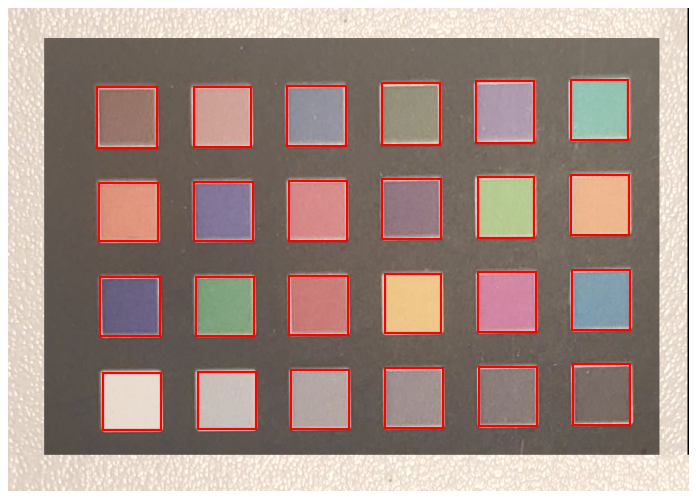

In [12]:
plt.figure(figsize=(12, 8), dpi=80)

for c in square_contours:
    x, y, w, h = cv2.boundingRect(c)
    rect = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    plt.gca().add_patch(rect)

plt.axis('off')
plt.imshow(image_8_bit)
plt.show()

## Crop squares and calculate their mean color

In [13]:
squares = []
square_colors = []
for cnt in square_contours:
    x, y, w, h = cv2.boundingRect(cnt)

    square_image = image_8_bit[y:y + h, x:x + w].copy()
    square_color = np.mean(square_image, axis=(0, 1))
    
    squares.append(square_image)
    square_colors.append(square_color)

square_colors[0]

array([ 232.16850238,  218.83527865,  206.49745192])